# Planning for College
An analysis of how the price of university has changed over time along with a comparison of different possible investment portfolios that families could use to save for their children to go to college.
### Goals
* Use historical tuition data to predict the price of tuition for the year a child will start college
* Assuming an initial investment of a certain dollar amount, use monte carlo simulations to predict how savings portfolios of different weights will compare to each other
* Given the results of these simulations, provide a framework for families to set expectations for their children for how much of their tuition will be covered by the family's savings, and how much of it will have to come from outside sources such as loans, grants, and/or scholarships.

### Research questions
* How much has the price of university changed over the past 60 years after accounting for inflation?
* How much can we expect the price to increase each year?
* What is the average difference in price between public and private university?
* With an initial investment of 10,000 dollars, how much can a family expect to have saved after 10 years for each portfolio? How does that compare to the predicted cost of university after 10 years?
* Is one portfolio better than another in the given scenario?

In [91]:
#import the dependecies for the project
import pandas as pd
import numpy as np
from pathlib import Path
import os
import alpaca_trade_api as tradeapi
from stock_data_analysis.MCForecastTools import MCSimulation
import hvplot.pandas
import altair as alt
from dotenv import load_dotenv
from bokeh.models import HoverTool
%matplotlib inline

## Part 1: Analyzing the Tuition Data
In this section, we will prepare and analyze data taken from the [National Center for Education Statistics](https://nces.ed.gov/programs/digest/d21/tables/dt21_330.10.asp).

### Which data to use for the analysis?
The initial DataFrame that we created after importing the CSV file contained a variety pricing data, such as the costs of tuition, fees, and room and board, as well as all of those costs together. For the purpose of this project, we decided only to use the data for tuition, fees, and room and board together. In addition, the file provided data showing the actual dollar amount for the years provided, as well as those prices adjusted for inflation. In order to create more accurate predicitons, we decided to use only the inflation-adjusted data for our analysis.

The notebook `separating_dataframes.ipynb` shows the process of separating and cleaning the data from the initial CSV file into three different DataFrames, then saving those DataFrames to their own CSV files to be used in our other notebooks. These DataFrames contain average pricing data for all public institutions, all private institutions, and both types together.

In [2]:
#read in CSV files for each type of institution
public_df = pd.read_csv(
    Path('./tuition_price_analysis/Resources/public_institutions.csv'),
    index_col='Year'
)

all_institutions_df = pd.read_csv(
    Path('./tuition_price_analysis/Resources/all_institutions.csv'),
    index_col='Year'
)

all_private_df = pd.read_csv(
    Path('./tuition_price_analysis/Resources/all_private_institutions.csv'),
    index_col='Year'
)

In [3]:
#display heads for each DataFrame
display(public_df.head())
display(all_private_df.head())
display(all_institutions_df.head())

,All Institutions,4-year,2-year
Year,,,
1963-64,7785,7923,5375
1968-69,8201,8433,6515
1969-70,8336,8624,6625
1970-71,8453,8783,6611
1971-72,8614,8984,6862


,All Institutions,4-year,2-year
Year,,,
1963-64,15486,15441,11203
1968-69,17124,17383,13841
1969-70,17607,17825,13884
1970-71,18078,18247,13931
1971-72,18560,18664,13979


,All Institutions,4-year,2-year
Year,,,
1963-64,10648,10973,6616
1968-69,10762,11401,7769
1969-70,10868,11665,7589
1970-71,10948,11820,7422
1971-72,11066,12007,7493


There was a formatting error in the index for the 1985-1986 year, so we edited the index to fix the error.

In [4]:
#correct the year 1985-86 for all dataframes
index = public_df.index              
index_list = index.tolist()
index_list[18] = '1985-86'

public_df.index=index_list
public_df.index.name='Year'

all_private_df.index=index_list
all_private_df.index.name='Year'

all_institutions_df.index=index_list
all_institutions_df.index.name='Year'

For this analysis, we chose to only analyze the pricing data for a traditional four-year education.

In [5]:
#drop the 'all institutions' and '2-year' columns to focus only on 4-year expenses.
all_institutions_4_year = all_institutions_df.drop(columns=['All Institutions', '2-year'])

private_4_year = all_private_df.drop(columns=['All Institutions', '2-year'])

public_4_year = public_df.drop(columns=['All Institutions', '2-year'])
public_4_year.head()

,4-year
Year,
1963-64,7923
1968-69,8433
1969-70,8624
1970-71,8783
1971-72,8984


We then concatenate the 4-year data from each type into one DataFrame

In [6]:
#concatenate the dataframes
all_tuition_df = pd.concat(
    [all_institutions_4_year, private_4_year, public_4_year],
    axis='columns',
    join='inner')

#rename columns
columns = ['All Institutions', 'Private', 'Public']
all_tuition_df.columns=columns
all_tuition_df.tail()

,All Institutions,Private,Public
Year,,,
2016-17,28838,44967,21134
2017-18,29013,45743,21263
2018-19,28121,46414,21401
2019-20,29436,46982,21520
2020-21,29033,46313,21337


In [96]:
all_tuition_df.describe()

,All Institutions,Private,Public
count,54.000000,54.000000,54.000000
mean,18291.222222,29164.277778,13047.888889
std,6495.464344,9896.299999,4711.401493
min,10631.000000,15441.000000,7747.000000
25%,11879.500000,18748.750000,8903.000000
50%,16875.500000,28834.000000,11563.000000
75%,24005.750000,37498.000000,16644.500000
max,29436.000000,46982.000000,21520.000000


## Research Question: What is the average difference in price between public and private university?
Adjusted for inflation, the summary statistics from the `all_tuition_df` DataFrame show a mean total cost per year of 29,164 dollars for private university, and a mean total cost per year of 13047 dollars per year for public university over all of the years studied, making the average difference 16117 dollars per year.

The following visualization shows the change over time for each type of institution.

In [7]:
all_tuition_df.hvplot(
    xlabel='School Year',
    ylabel='Total Tuition/Fees/Room and Board',
    title='Total Average University Expenses by Year - Adjusted for Inflation',
    rot=90
).opts(
    height=350,
    width=900
)

:NdOverlay   [Variable]
   :Curve   [Year]   (value)

## Research Question: How much has the price of university changed over the past 60 years after accounting for inflation?
##### Adjusted for inflation, the average total cost across all institutions for one year of university for the 1963-1964 school year was 10,973 dollars. For the 2020-2021 school year, it was 29,033 dollars. This shows an increase in cost per year of 18,060 dollars between 1963 and 2021.

Now that we have the pricing data for all of the institutions in the same dataframe, we can calculate the percent change for each year.

In [8]:
#create a dataframe for the percentage changes for each institution type
tuition_pct_change = all_tuition_df.pct_change().dropna()
tuition_pct_change.head()

,All Institutions,Private,Public
Year,,,
1968-69,0.039005,0.125769,0.064370
1969-70,0.023156,0.025427,0.022649
1970-71,0.013288,0.023675,0.018437
1971-72,0.015821,0.022853,0.022885
1972-73,0.039644,0.018163,0.062890


We can visualize the percent changes for each year using bar charts:

In [9]:
#chart configuration for all institutions
alt.Chart(tuition_pct_change.reset_index()).mark_bar().encode(
    x='Year',
    y=alt.Y('All Institutions', title='Percent Change')
).properties(
    title='Percent Change Per Year - All Institutions'
).configure_title(
    'center',
    fontSize=16
)

alt.Chart(...)

In [10]:
#chart configuration for private institutions
alt.Chart(tuition_pct_change.reset_index()).mark_bar().encode(
    x='Year',
    y=alt.Y('Private', title='Percent Change')
).properties(
    title='Percent Change Per Year - Private Institutions'
).configure_title(
    'center',
    fontSize=16
)

alt.Chart(...)

In [11]:
#chart configuration for public institutions
alt.Chart(tuition_pct_change.reset_index()).mark_bar().encode(
    x='Year',
    y=alt.Y('Public', title='Percent Change')
).properties(
    title='Percent Change Per Year - Public Institutions'
).configure_title(
    'center',
    fontSize=16
)

alt.Chart(...)

We can also use the `describe()` function to gain insight into these changes.

## Research Question: How much can we expect the price to increase each year?
##### These statistics tell us that, overall, the price of tuition between all institutions increased by around 2 percent each year. Since the goal of our project is to give families a ballpark estimate of how much they can expect college to cost after a certain number of years, we can calculate the estimated cost by assuming a 2 percent increase for each year.

In [12]:
tuition_pct_change.describe()

,All Institutions,Private,Public
count,53.000000,53.000000,53.000000
mean,0.018866,0.021298,0.019259
std,0.026222,0.027375,0.028221
min,-0.061418,-0.048834,-0.071270
25%,0.009780,0.011358,0.009323
50%,0.022059,0.020849,0.022649
75%,0.036244,0.030422,0.035827
max,0.069243,0.125769,0.067389


Assuming this 2 percent increase and using the most recent pricing data as a starting point, we can use the Future Value formula to calculate a price estimate over a certain number of years. In the following example, we use this formula to estimate the total costs for a public institution in 2031.

In [13]:
#a function to calculate the future price
def calculate_future_price(current_price, number_of_years):
    future_price = current_price * (1 + .02) ** number_of_years
    return future_price

#call the function with a starting value of 21337 and a period of 10 years.
price_2031 = calculate_future_price(21337, 10)
price_2031

26009.683939428138

## Part 2: Comparing Portfolios
In simulating these different stock portfolios, our goal is to provide an alternative to a traditional savings account that would allow families to invest in their children's future education while mitigating risk. We decided to keep these portfolios simple by composing them of two Exchange-Traded Funds (ETFs), the SPDR S&P 500 ETF Trust (SPY), and the iShares Core US Aggregate Bond ETF (AGG). By providing Monte Carlo simulations of different weights, we are able to provide a tool for families to make an informed decision on which type of portfolio would best meet their needs.

### Collecting the Data
We used the Alpaca Trade API to collect data for the two ETFs and calculate the daily returns for each. We then used that daily return data as the basis for our Monte Carlo simulations.

In [16]:
#load the API credentials from the environment file
load_dotenv()

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [17]:
#create an alpaca REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [18]:
#set tickers, timeframe, and start and end date
tickers = ["SPY", "AGG"]
timeframe = "1Day"
start_date = pd.Timestamp("1990-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

Originally we wanted to get 31 years of stock data, but were only able to get 7 with the free API.

In [20]:
#generate a dataframe of the stock data
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

df_portfolio.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,108.54,108.8400,108.43,108.82,4259986,15562,108.754152,AGG
2015-12-02 05:00:00+00:00,108.73,108.7799,108.61,108.67,2462787,11581,108.684692,AGG
2015-12-03 05:00:00+00:00,108.41,108.4100,107.81,107.89,4634020,16801,108.040315,AGG
2015-12-04 05:00:00+00:00,108.05,108.3000,108.00,108.24,2182057,9796,108.192232,AGG
2015-12-07 05:00:00+00:00,108.30,108.5800,108.23,108.40,2143773,9104,108.460067,AGG


#### Concatenating the DataFrames

In [22]:
#concatenate the dataframes
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)

df_portfolio_year = pd.concat([SPY, AGG],axis=1, keys=['SPY','AGG'])

# set in ascending order (past to present)
df_portfolio_year = df_portfolio_year.sort_index()

df_portfolio_year.head()

SPY                                         \
                             open      high       low   close     volume   
timestamp                                                                  
2015-12-01 05:00:00+00:00  209.42  210.8200  209.1100  210.68   97858418   
2015-12-02 05:00:00+00:00  210.60  211.0000  208.2300  208.54  108069059   
2015-12-03 05:00:00+00:00  208.90  209.1500  204.7511  205.58  166224154   
2015-12-04 05:00:00+00:00  206.10  209.9700  205.9300  209.66  192878747   
2015-12-07 05:00:00+00:00  209.20  209.7295  207.2000  208.27  102027111   

                                                      AGG                    \
                          trade_count        vwap    open      high     low   
timestamp                                                                     
2015-12-01 05:00:00+00:00      337780  209.921410  108.54  108.8400  108.43   
2015-12-02 05:00:00+00:00      367013  209.563055  108.73  108.7799  108.61   
2015-12-03 05:00:00+00:00      546768  206.878936  108.41  108.4100  107.81   
2015-12-04 05:00:00+00:00      556731  208.178631  108.05  108.3000  108.00   
2015-12-07 05:00:00+00:00      374705  208.276128  108.30  108.5800  108.23   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2015-12-01 05:00:00+00:00  108.82  4259986       15562  108.754152  
2015-12-02 05:00:00+00:00  108.67  2462787       11581  108.684692  
2015-12-03 05:00:00+00:00  107.89  4634020       16801  108.040315  
2015-12-04 05:00:00+00:00  108.24  2182057        9796  108.192232  
2015-12-07 05:00:00+00:00  108.40  2143773        9104  108.460067

To generate our daily returns DataFrame, we only needed the closing prices for each stock, so we dropped all other columns and then used the `pct_change` function to get the daily returns.

In [49]:
df_closing_prices = pd.DataFrame()

df_closing_prices["SPY"] = df_portfolio_year["SPY"]["close"]
df_closing_prices["AGG"] = df_portfolio_year["AGG"]["close"]

df_closing_prices.index = df_closing_prices.index.date
df_closing_prices.tail()

,SPY,AGG
2021-12-27,477.26,114.26
2021-12-28,476.87,114.21
2021-12-29,477.48,113.87
2021-12-30,476.16,114.12
2021-12-31,474.96,114.08


In [48]:
df_daily_returns = df_closing_prices.pct_change().dropna()

df_daily_returns.head(10)

,SPY,AGG
2015-12-02,-0.010158,-0.001378
2015-12-03,-0.014194,-0.007178
2015-12-04,0.019846,0.003244
2015-12-07,-0.006630,0.001478
2015-12-08,-0.006146,0.000369
2015-12-09,-0.008020,0.000000
2015-12-10,0.002581,-0.000184
2015-12-11,-0.019334,0.002490
2015-12-14,0.005548,-0.004692
2015-12-15,0.010148,0.000092


### Creating and Analyzing Monte Carlo Simulations
Now that we have the daily returns for the two ETFs, we can create our simulation objects. The first simulation will have an 80/20 weight between SPY and AGG, generating 500 simulations over 10 years. This will represent our higher risk portfolio, since it is composed of 80% stocks and 20% bonds. We will also create a simulation for a lower-risk portolio composed of 20% stocks and 80% bonds, and a balanced portfolio equally weighted between stocks and bonds.

We chose the 10 year number for our simulations to represent a scenario where the child we are saving for is currently 8 years old, so we would expect them to go to college in 10 years. The simulations could be easily adjusted to account for children of different ages.

In [27]:
# Create a simulation object
higher_risk_df = MCSimulation(
    portfolio_data=df_portfolio_year,
    weights=[0.80, 0.20],
    num_simulation=500,
    num_trading_days=252*10,
)

In [28]:
#run the simulations
higher_risk_df.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\lydia\OneDrive\Boot_camp\Projects\Project_1\Project-1\stock_data_analysis\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.977890,0.985385,1.021881,1.002600,1.003925,1.000211,0.984341,1.013997,0.997949,0.989537,...,1.013760,0.995011,1.004221,0.993195,1.000186,0.996736,0.998773,1.005968,1.009850,0.975163
2,0.974924,0.996426,1.037639,1.001812,1.027253,0.995361,0.976865,1.016196,0.998165,0.988021,...,1.022014,1.007080,1.014400,0.998759,0.998970,0.988269,1.006773,1.008932,1.004719,0.976338
3,0.962088,1.003820,1.037580,1.012576,1.024545,0.994714,0.967451,1.007948,1.008174,0.975279,...,1.018239,0.996685,1.022281,1.001795,1.007541,0.993259,1.008217,1.036109,1.005000,0.990924
4,0.957306,1.008341,1.033138,1.007382,1.017438,0.993326,0.954131,1.001619,1.016048,0.967950,...,1.000495,1.003741,1.028083,0.998724,1.011161,0.987333,1.013070,1.050033,1.010503,0.989953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.196956,2.995346,3.728934,2.647202,1.253884,1.608236,7.163896,2.084152,3.083871,7.286975,...,3.085138,2.248541,2.538264,3.688012,3.846747,5.116865,2.685341,5.492536,1.751616,3.946548
2517,2.169529,3.006542,3.745568,2.663491,1.265379,1.618463,7.103882,2.101501,3.094605,7.358182,...,3.025436,2.266006,2.541089,3.705823,3.833931,5.062426,2.649456,5.537280,1.758469,3.999603
2518,2.165276,3.014201,3.754695,2.673576,1.255201,1.627511,7.125347,2.117152,3.058866,7.310508,...,3.087584,2.257648,2.597211,3.728068,3.821797,5.041197,2.679217,5.589181,1.776501,4.065083
2519,2.160724,3.013503,3.750084,2.668008,1.238986,1.635827,7.152688,2.098133,3.059778,7.309501,...,3.088995,2.276697,2.575130,3.723673,3.823167,4.968078,2.644112,5.624983,1.774817,4.078278


Here we repeat the process to create a lower risk simulation with a 20% weight in stocks and an 80% weight in bonds.

In [30]:
# Set weights for low risk portfolio (20% SPY, 80% AGG)
low_risk_df = MCSimulation(
    portfolio_data=df_portfolio_year,
    weights=[0.20, 0.80],
    num_simulation=500,
    num_trading_days=252*10,
)

In [31]:
low_risk_df.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\lydia\OneDrive\Boot_camp\Projects\Project_1\Project-1\stock_data_analysis\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999067,1.001574,1.007279,0.997329,0.996035,1.002545,1.004648,0.997403,0.996686,0.995454,...,1.001585,0.999147,0.998827,1.000468,1.004067,1.000462,1.002134,0.999532,1.005660,0.997763
2,0.996580,1.002698,1.012944,1.001548,0.997678,1.002504,1.003819,0.998767,0.994895,0.998545,...,1.002151,0.999495,0.999121,1.005000,1.002931,1.000532,1.003748,1.001085,1.005396,1.001262
3,0.999095,1.006210,1.017287,1.005192,0.995427,1.005564,1.002832,0.995811,0.991043,0.993553,...,1.010193,0.994081,1.000043,1.008668,1.005505,0.998720,1.000060,0.999352,1.001857,1.000480
4,1.002003,1.004145,1.018714,1.009721,0.997009,1.003141,1.005756,0.997088,0.992862,1.003602,...,1.016216,0.996258,0.997375,1.005491,1.005125,0.993282,0.997603,0.999848,1.002477,0.997810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.696019,1.695447,1.480418,1.042275,1.795169,1.846055,1.633131,1.353140,1.381629,1.319815,...,1.577779,1.141073,0.943737,1.669441,1.187813,1.250252,1.515285,1.506384,1.687462,1.651353
2517,1.702392,1.697324,1.483430,1.044437,1.793326,1.846680,1.633894,1.356246,1.382779,1.319997,...,1.576378,1.150290,0.942055,1.670746,1.185972,1.249740,1.511427,1.509418,1.699354,1.653527
2518,1.704420,1.693601,1.475529,1.050237,1.794972,1.838154,1.628131,1.353759,1.387739,1.326078,...,1.568539,1.153125,0.946588,1.667102,1.174154,1.246444,1.516230,1.514582,1.700886,1.647072
2519,1.702789,1.683256,1.478878,1.049026,1.795006,1.827430,1.627244,1.362523,1.381349,1.322958,...,1.563391,1.151028,0.946030,1.656616,1.181134,1.246386,1.516348,1.515209,1.701141,1.639292


Finally, our third simulation: a portfolio weighted equally between stocks and bonds.

In [34]:
#Create a simulation object for the equally weighted portfolio
equal_weight_df = MCSimulation(
    portfolio_data=df_portfolio_year,
    weights=[0.50, 0.50],
    num_simulation=500,
    num_trading_days=252*10,
)

In [35]:
equal_weight_df.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\lydia\OneDrive\Boot_camp\Projects\Project_1\Project-1\stock_data_analysis\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996822,0.996604,1.005705,1.001917,0.995157,0.998532,0.998243,0.996348,1.002935,1.007347,...,1.009164,0.997267,1.004062,1.003355,1.013908,0.998951,0.999691,1.004699,1.001392,0.999217
2,1.004035,1.002972,1.012136,0.994600,0.990850,1.000752,1.009002,0.988260,0.999164,1.003466,...,1.016435,1.000424,1.003725,0.992697,1.014584,1.006607,0.998142,1.011788,1.000887,1.000290
3,1.008186,0.996644,1.004127,0.992739,0.979654,0.997151,1.011147,0.996260,1.006131,1.013920,...,1.017943,1.007015,0.998115,0.999718,1.020729,1.012474,0.994336,1.014860,1.001191,1.012826
4,1.008464,1.003133,1.003659,0.995174,0.971294,1.002403,1.015762,0.992283,1.018960,1.006409,...,1.011720,1.002920,0.998248,1.008380,1.026001,1.013728,0.991808,1.015617,0.994613,1.007684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.198983,2.505947,3.323356,1.322386,1.033192,2.421188,2.925314,2.657922,1.659729,2.319778,...,1.370197,2.645429,2.308880,2.280920,1.730037,2.585479,2.207674,2.072438,1.884996,2.074089
2517,2.213511,2.529040,3.345322,1.321586,1.023895,2.389688,2.912638,2.669679,1.660033,2.321234,...,1.376905,2.661549,2.302104,2.299426,1.716084,2.600737,2.180883,2.079979,1.888924,2.068665
2518,2.223109,2.548651,3.335918,1.328942,1.018891,2.381303,2.888325,2.670199,1.667798,2.345445,...,1.374929,2.640569,2.321173,2.283115,1.724547,2.609807,2.199667,2.070341,1.902081,2.065443
2519,2.219201,2.542954,3.361737,1.310079,1.020061,2.367668,2.918073,2.683660,1.664786,2.320674,...,1.380257,2.619430,2.328587,2.291134,1.750881,2.620768,2.198976,2.069869,1.907272,2.039619


### Analyzing the Simulations
We analyzed the results of our simulations in a few different ways, such as visualizing the cumulative returns and generating summary statistics.

#### A visualization of the cumulative returns for the higher risk portfolio:

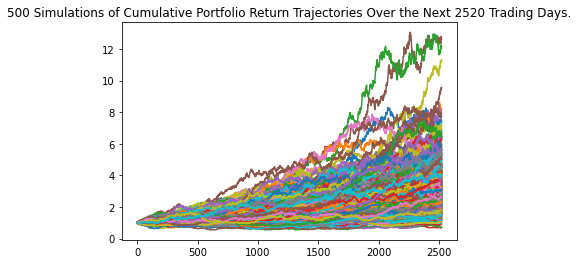

In [32]:
higher_risk_mc_sim = higher_risk_df.plot_simulation()

#### A visualization of the cumulative returns for the lower risk portfolio:

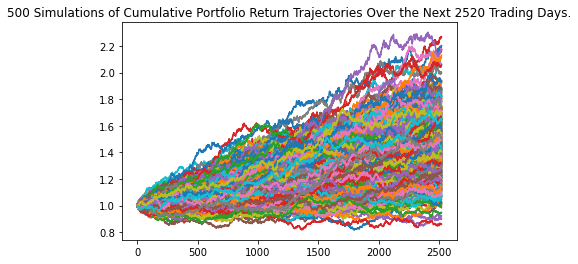

In [33]:
low_risk_mc_sim = low_risk_df.plot_simulation()

#### A visulization of the cumulative returns for the equally weighted portfolio

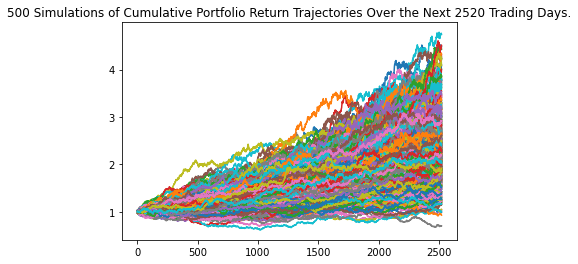

In [36]:
equal_weighted_mc_sim = equal_weight_df.plot_simulation()

To get a better idea of what these simulations are telling us, we will generate and plot the summary statistics for each portfolio

In [46]:
# get summary statistics for the higher risk portfolio
higher_risk_sim_returns = {
    "mean": list(higher_risk_df.simulated_return.mean(axis=1)),
    "median": list(higher_risk_df.simulated_return.median(axis=1)),
    "min": list(higher_risk_df.simulated_return.min(axis=1)),
    "max": list(higher_risk_df.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
higher_risk_sim_returns = pd.DataFrame(higher_risk_sim_returns)

In [38]:
# get summary statistics for the lower risk portfolio
low_risk_sim_returns = {
    "mean": list(low_risk_df.simulated_return.mean(axis=1)),
    "median": list(low_risk_df.simulated_return.median(axis=1)),
    "min": list(low_risk_df.simulated_return.min(axis=1)),
    "max": list(low_risk_df.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
low_risk_sim_returns = pd.DataFrame(low_risk_sim_returns)

In [43]:
# get summary statistics for equal weight portfolio
equal_weight_sim_returns = {
    "mean": list(equal_weight_df.simulated_return.mean(axis=1)),
    "median": list(equal_weight_df.simulated_return.median(axis=1)),
    "min": list(equal_weight_df.simulated_return.min(axis=1)),
    "max": list(equal_weight_df.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
equal_weight_sim_returns = pd.DataFrame(equal_weight_sim_returns)

<AxesSubplot:title={'center':'Simulated Cumulative Returns of 50/50 Portfolio Over the Next 10 Years'}>

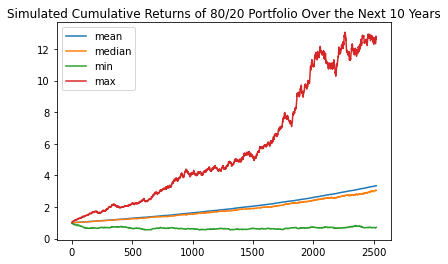

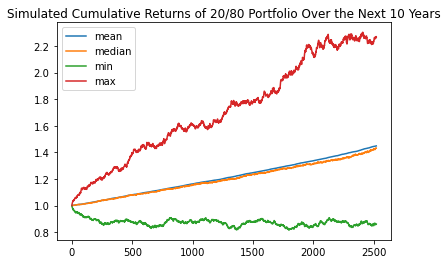

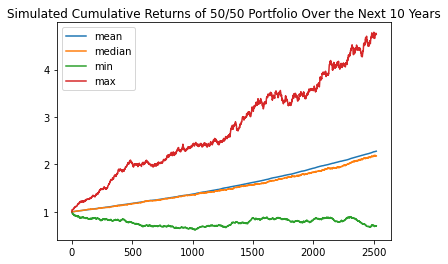

In [44]:
#plot the summary statistics for each portfolio
higher_risk_sim_returns.plot(title="Simulated Cumulative Returns of 80/20 Portfolio Over the Next 10 Years")
low_risk_sim_returns.plot(title="Simulated Cumulative Returns of 20/80 Portfolio Over the Next 10 Years")
equal_weight_sim_returns.plot(title="Simulated Cumulative Returns of 50/50 Portfolio Over the Next 10 Years")

### Using Summary Statistics to Calculate Possible Outcomes
Here we will use summary statistics to calculate the possible outcomes for each portfolio. Using a 95% confidence interval, we can get an idea of the general range of outcomes, along with looking at the mean and median outcomes.

In this scenario, we will assume that a family with an 8-year-old child has made an initial investment of $10,000.

In [60]:
initial_investment = 10000

In [61]:
# Generate summary statistics for the higher risk portfolio simulation
# Save the results as a variable
higher_risk_summary_statistics = higher_risk_df.summarize_cumulative_return()

# Review the 10-year Monte Carlo summary statistics
higher_risk_summary_statistics

count           500.000000
mean              3.340685
std               1.577030
min               0.699907
25%               2.244823
50%               3.050663
75%               4.170794
max              12.619744
95% CI Lower      1.226335
95% CI Upper      6.891661
Name: 2520, dtype: float64

In [62]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the higher-risk portfolio
ci_lower_hrp_cumulative_return = higher_risk_summary_statistics[8] * initial_investment
ci_upper_hrp_cumulative_return = higher_risk_summary_statistics[9] * initial_investment
hrp_cumulative_return_mean = higher_risk_summary_statistics[1] * initial_investment

# Print the result of your calculations
print(f"Based on 500 simulations of cumulative returns taken from 7 years of daily return data, there is a 95% chance that an initial investment of ${initial_investment} "
f"with an 80/20 stock/bond distribution over the next 10 years will end within a range of ${ci_lower_hrp_cumulative_return:.2f} and ${ci_upper_hrp_cumulative_return:.2f}, with a mean expected return of ${hrp_cumulative_return_mean:.2f}.")

Based on 500 simulations of cumulative returns taken from 7 years of daily return data, there is a 95% chance that an initial investment of $10000 with an 80/20 stock/bond distribution over the next 10 years will end within a range of $12263.35 and $68916.61, with a mean expected return of $33406.85.


Repeat this process for the two other portfolios:

In [66]:
# Generate summary statistics for the lower risk portfolio simulation
# Save the results as a variable
lower_risk_summary_statistics = low_risk_df.summarize_cumulative_return()

# Review the 10-year Monte Carlo summary statistics
lower_risk_summary_statistics

count           500.000000
mean              1.448340
std               0.235114
min               0.860396
25%               1.288311
50%               1.431536
75%               1.595632
max               2.268080
95% CI Lower      1.040470
95% CI Upper      1.928513
Name: 2520, dtype: float64

In [71]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the lower-risk portfolio
ci_lower_lrp_cumulative_return = lower_risk_summary_statistics[8] * initial_investment
ci_upper_lrp_cumulative_return = lower_risk_summary_statistics[9] * initial_investment
lrp_cumulative_return_mean = lower_risk_summary_statistics[1] * initial_investment

# Print the result of your calculations
print(f"Based on 500 simulations of cumulative returns taken from 7 years of daily return data, there is a 95% chance that an initial investment of ${initial_investment} "
f"with a 20/80 stock/bond distribution over the next 10 years will end within a range of ${ci_lower_lrp_cumulative_return:.2f} and ${ci_upper_lrp_cumulative_return:.2f}, with a mean expected return of ${lrp_cumulative_return_mean:.2f}.")

Based on 500 simulations of cumulative returns taken from 7 years of daily return data, there is a 95% chance that an initial investment of $10000 with a 20/80 stock/bond distribution over the next 10 years will end within a range of $10404.70 and $19285.13, with a mean expected return of $14483.40.


In [72]:
# Generate summary statistics for the equal weight portfolio simulation
# Save the results as a variable
equal_weight_summary_statistics = equal_weight_df.summarize_cumulative_return()

# Review the 10-year Monte Carlo summary statistics
equal_weight_summary_statistics

count           500.000000
mean              2.279896
std               0.686678
min               0.702349
25%               1.801327
50%               2.178910
75%               2.648103
max               4.742700
95% CI Lower      1.198188
95% CI Upper      3.934874
Name: 2520, dtype: float64

In [73]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the equal weight portfolio
ci_lower_ewp_cumulative_return = equal_weight_summary_statistics[8] * initial_investment
ci_upper_ewp_cumulative_return = equal_weight_summary_statistics[9] * initial_investment
ewp_cumulative_return_mean = equal_weight_summary_statistics[1] * initial_investment

# Print the result of your calculations
print(f"Based on 500 simulations of cumulative returns taken from 7 years of daily return data, there is a 95% chance that an initial investment of ${initial_investment} "
f"with a 50/50 stock/bond distribution over the next 10 years will end within a range of ${ci_lower_ewp_cumulative_return:.2f} and ${ci_upper_ewp_cumulative_return:.2f}, with a mean expected return of ${ewp_cumulative_return_mean:.2f}.")

Based on 500 simulations of cumulative returns taken from 7 years of daily return data, there is a 95% chance that an initial investment of $10000 with a 50/50 stock/bond distribution over the next 10 years will end within a range of $11981.88 and $39348.74, with a mean expected return of $22798.96.


## Research Question: With an initial investment of 10,000 dollars, how much can a family expect to have saved after 10 years for each portfolio? How does that compare to the predicted cost of university after 10 years?
The following DataFrame and bar chart show the expected results of each portfolio in comparison to the average cost per year of university. We can see that in some scenarios the initial investment of 10,000 dollars could be enough to cover one year of university costs, however since most students take around four years to complete their bachelor's degree, it would not come close to covering the full expense.

To make up for this discrepancy, the family could make a higher initial investment and/or add more shares into the portfolio over time. Of course, there are also many other ways for students to pay for education as well, such as scholarships, grants, and loans.

In [94]:
#create a DataFrame to compare the expected returns
comparison_df = pd.DataFrame(
        {'Lower Risk':[lrp_cumulative_return_mean, ci_lower_lrp_cumulative_return, ci_upper_lrp_cumulative_return],
         'Higher Risk':[hrp_cumulative_return_mean, ci_lower_hrp_cumulative_return, ci_upper_hrp_cumulative_return],
         'Equal Weight':[ewp_cumulative_return_mean, ci_lower_ewp_cumulative_return, ci_upper_ewp_cumulative_return],
         '2031 Expected Price/Yr':price_2031
        }
)
#set the index for the DataFrame
sim_index = ['mean return', 'lower-bound return', 'upper-bound return']
comparison_df.index = sim_index
comparison_df

,Lower Risk,Higher Risk,Equal Weight,2031 Expected Price/Yr
mean return,14483.403862,33406.849703,22798.961918,26009.683939
lower-bound return,10404.703683,12263.351380,11981.876394,26009.683939
upper-bound return,19285.130522,68916.607184,39348.738092,26009.683939


In [95]:
#configure the hover to display standard notation
hover = HoverTool(
    tooltips=[
        ( 'value', '@value{0.00 a}'      ),
    ]
)
#configure bar chart
comparison_df.hvplot.bar(
    ylabel='Expected Return in Dollars',
    title='Simulated Returns of Three College Savings Portfolios v. Cost per Year Prediction',
    rot=90
).opts(
    tools=[hover]
)

:Bars   [index,Variable]   (value)

## Research Question: Is one portfolio better than another in the given scenario?
In our simulations, the higher-risk portfolio appears to have performed better than the other two, even in the lower-bound prediction, although the difference was minimal. Since we only evaluated ETFs, which are less risky overall than investing in individual stocks, it seems that the increased level of risk for our higher-risk portfolio did not hurt its performance enough to decrease its attractiveness as an investment option.